In [1]:
import src
import pandas as pd
import numpy as np
from pathlib import Path

/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_dir = Path('/Users/raeed/Library/CloudStorage/OneDrive-UniversityofPittsburgh/0-projects/cst-strat/cst-data/library/human cst-rtt/')
# filename = 'CST_CRS02b_06-03-2024.mat'
filename = 'CST_CRS07_06-07-2024.mat'
td = src.rnel_preproc.load_ts_data(
    filename=data_dir / filename,
    cols_to_expose=['Kin'],
    index_cols=[
        'trial',
        'task',
        'state',
        'session_time',
    ],
    signal_cols=[
        'pos',
        'vel',
        'targetpos',
        'targetvel',
        'Motor',
        'Sensory',
    ],
)

In [143]:
td.reset_index(level='state')['state'].unique()

array(['', 'center', 'presentation', 'reach', 'pretrial'], dtype=object)

In [3]:
(
    td
    .pipe(src.munge.reindex_by_trial_time)
    .reset_index(level='state')['state']
    .pipe(src.munge.get_state_transition_times,timecol='trial_time')
    .loc[2:4]
)

trial  task  new_state   
2      RTT   center         0 days 00:00:00.180000
             presentation   0 days 00:00:01.980000
             reach                 0 days 00:00:03
3      RTT   center         0 days 00:00:00.160000
             presentation   0 days 00:00:02.920000
             reach          0 days 00:00:03.940000
4      CST   center         0 days 00:00:00.160000
             presentation   0 days 00:00:03.500000
             reach          0 days 00:00:04.520000
             intertrial     0 days 00:00:09.360000
Name: trial_time, dtype: timedelta64[ns]

In [179]:
(
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.reindex_from_event, event='reach')
)

signal                                                   pos            vel  \
channel                                                    0         1    0   
trial relative time            state    phase task                            
1     -1 days +23:59:57.500000 pretrial reach CST   0.007186 -0.003327  0.0   
      -1 days +23:59:57.520000 pretrial reach CST   0.007186 -0.003327  0.0   
      -1 days +23:59:57.540000 pretrial reach CST   0.007186 -0.003327  0.0   
      -1 days +23:59:57.560000 pretrial reach CST   0.007186 -0.003327  0.0   
      -1 days +23:59:57.580000 pretrial reach CST   0.007186 -0.003327  0.0   
...                                                      ...       ...  ...   
155   0 days 00:00:05.960000   reach    reach RTT   0.019418  0.002024  NaN   
      0 days 00:00:05.980000   reach    reach RTT   0.019418  0.002024  NaN   
      0 days 00:00:06          reach    reach RTT   0.019418  0.002024  NaN   
      0 days 00:00:06.020000   reach    reach RTT   0.019418  0.002024  NaN   
      0 days 00:00:06.040000   reach    reach RTT        NaN       NaN  NaN   

signal                                                  targetpos       \
channel                                               1         0    1   
trial relative time            state    phase task                       
1     -1 days +23:59:57.500000 pretrial reach CST   0.0  0.000000  0.0   
      -1 days +23:59:57.520000 pretrial reach CST   0.0  0.000000  0.0   
      -1 days +23:59:57.540000 pretrial reach CST   0.0  0.000000  0.0   
      -1 days +23:59:57.560000 pretrial reach CST   0.0  0.000000  0.0   
      -1 days +23:59:57.580000 pretrial reach CST   0.0  0.000000  0.0   
...                                                 ...       ...  ...   
155   0 days 00:00:05.960000   reach    reach RTT   NaN -0.024213  0.0   
      0 days 00:00:05.980000   reach    reach RTT   NaN -0.024213  0.0   
      0 days 00:00:06          reach    reach RTT   NaN -0.024213  0.0   
      0 days 00:00:06.020000   reach    reach RTT   NaN -0.024213  0.0   
      0 days 00:00:06.040000   reach    reach RTT   NaN       NaN  NaN   

signal                                             targetvel      Motor       \
channel                                                    0    1     0    1   
trial relative time            state    phase task                             
1     -1 days +23:59:57.500000 pretrial reach CST   0.041184  0.0   0.0  0.0   
      -1 days +23:59:57.520000 pretrial reach CST   0.041184  0.0   0.0  0.0   
      -1 days +23:59:57.540000 pretrial reach CST   0.041184  0.0   0.0  1.0   
      -1 days +23:59:57.560000 pretrial reach CST   0.041184  0.0   0.0  0.0   
      -1 days +23:59:57.580000 pretrial reach CST   0.041184  0.0   0.0  0.0   
...                                                      ...  ...   ...  ...   
155   0 days 00:00:05.960000   reach    reach RTT        NaN  NaN   0.0  1.0   
      0 days 00:00:05.980000   reach    reach RTT        NaN  NaN   0.0  0.0   
      0 days 00:00:06          reach    reach RTT        NaN  NaN   0.0  0.0   
      0 days 00:00:06.020000   reach    reach RTT        NaN  NaN   0.0  0.0   
      0 days 00:00:06.040000   reach    reach RTT        NaN  NaN   0.0  0.0   

signal                                              ... Sensory            \
channel                                             ...      54   55   56   
trial relative time            state    phase task  ...                     
1     -1 days +23:59:57.500000 pretrial reach CST   ...     0.0  0.0  0.0   
      -1 days +23:59:57.520000 pretrial reach CST   ...     0.0  0.0  0.0   
      -1 days +23:59:57.540000 pretrial reach CST   ...     0.0  0.0  0.0   
      -1 days +23:59:57.560000 pretrial reach CST   ...     0.0  0.0  0.0   
      -1 days +23:59:57.580000 pretrial reach CST   ...     0.0  0.0  0.0   
...                                                 ...     ...  ...  ...   
155   0 days 00:00:05.960000   reach    re

In [148]:
(
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'presentation':slice('-2 sec','5 sec')})
)

/Users/raeed/codebase/0-projects/cst-dynamics/src/munge.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  td


signal                                               pos                 vel  \
channel                                                0         1         0   
trial relative time phase        task state                                    
1     -1.46         presentation CST  pretrial  0.007186 -0.003327  0.000000   
      -1.44         presentation CST  pretrial  0.007186 -0.003327  0.000000   
      -1.42         presentation CST  pretrial  0.007186 -0.003327  0.000000   
      -1.40         presentation CST  pretrial  0.007186 -0.003327  0.000000   
      -1.38         presentation CST  pretrial  0.007186 -0.003327  0.000000   
...                                                  ...       ...       ...   
155    4.92         presentation RTT  reach    -0.040212  0.014256  0.264511   
       4.94         presentation RTT  reach    -0.040212  0.014256  0.264511   
       4.96         presentation RTT  reach    -0.019571  0.013491  0.279800   
       4.98         presentation RTT  reach    -0.019571  0.013491  0.279800   
       5.00         presentation RTT  reach     0.025534  0.008140  0.279800   

signal                                                   targetpos       \
channel                                                1         0    1   
trial relative time phase        task state                               
1     -1.46         presentation CST  pretrial  0.000000  0.000000  0.0   
      -1.44         presentation CST  pretrial  0.000000  0.000000  0.0   
      -1.42         presentation CST  pretrial  0.000000  0.000000  0.0   
      -1.40         presentation CST  pretrial  0.000000  0.000000  0.0   
      -1.38         presentation CST  pretrial  0.000000  0.000000  0.0   
...                                                  ...       ...  ...   
155    4.92         presentation RTT  reach    -0.027521  0.009801  0.0   
       4.94         presentation RTT  reach    -0.027521  0.009801  0.0   
       4.96         presentation RTT  reach    -0.030579  0.106375  0.0   
       4.98         presentation RTT  reach    -0.030579  0.106375  0.0   
       5.00         presentation RTT  reach    -0.032108  0.106375  0.0   

signal                                         targetvel      Motor       ...  \
channel                                                0    1     0    1  ...   
trial relative time phase        task state                               ...   
1     -1.46         presentation CST  pretrial  0.041184  0.0   0.0  0.0  ...   
      -1.44         presentation CST  pretrial  0.041184  0.0   0.0  0.0  ...   
      -1.42         presentation CST  pretrial  0.041184  0.0   0.0  1.0  ...   
      -1.40         presentation CST  pretrial  0.041184  0.0   0.0  0.0  ...   
      -1.38         presentation CST  pretrial  0.041184  0.0   0.0  0.0  ...   
...                                                  ...  ...   ...  ...  ...   
155    4.92         presentation RTT  reach     0.042791  0.0   0.0  1.0  ...   
       4.94         presentation RTT  reach     0.042791  0.0   0.0  0.0  ...   
       4.96         presentation RTT  reach     0.042791  0.0   0.0  0.0  ...   
       4.98         presentation RTT  reach     0.042791  0.0   0.0  1.0  ...   
       5.00         presentation RTT  reach     0.042791  0.0   0.0  1.0  ...   

signal                                         Sensory                      \
channel                                             54   55   56   57   58   
trial relative time phase        task state                                  
1     -1.46         presentation CST  pretrial     0.0  0.0  0.0  0.0  0.0   
      -1.44         presentation CST  pretrial     0.0  0.0  0.0  0.0  0.0   
      -1.42         presentation CST  pretrial     0.0  0.0  0.0  0.0  0.0   
      -1.40         presentation CST  pretrial     0.0  0.0  0.0  0.0  0.0   
      -1.38         presentation CST  pretrial     0.0  0.0  0.0  0.0  0.0   
...                                                ...  ...  ...  ...

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_68983/521997861.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  td
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/

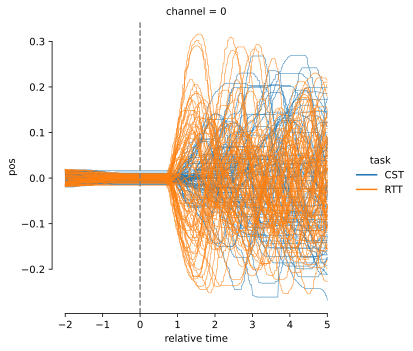

In [4]:
import seaborn as sns

signal = 'pos'
temp = (
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'reach':slice('-2 sec','5 sec')})
    [[signal]]
    .stack(level='signal')
    .rename_axis(index={'signal': 'signal type'})
    [[0]]
    .stack()
    .to_frame(signal)
)
g = sns.relplot(
    data=temp,
    x='relative time',
    y=signal,
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    row='channel',
    units='trial',
    estimator=None,
    errorbar=None,
    lw=0.5,
)
g.refline(x=0)
g.despine(trim=True)
g.tight_layout()


In [5]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

temp = (
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'presentation':slice('3 sec','6 sec')})
    .reset_index(level='task')
)

lda_pipe = Pipeline([
    ('pca', PCA(n_components=15)),
    ('lda', LinearDiscriminantAnalysis()),
])
lda_pipe.fit(temp['Motor'],temp['task'])


Pipeline(steps=[('pca', PCA(n_components=15)),
                ('lda', LinearDiscriminantAnalysis())])

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_68983/2987701558.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  td
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib

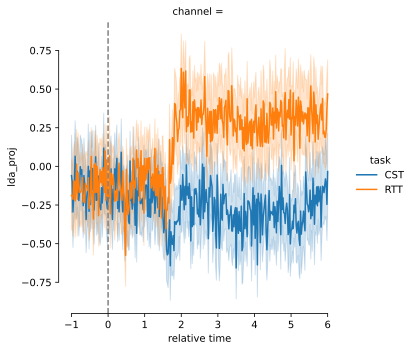

In [6]:
signal = 'lda_proj'
temp = (
    td
    .pipe(src.munge.reindex_by_trial_time)
    .pipe(src.munge.get_epoch_data,epochs={'presentation':slice('-1 sec','6 sec')})
    .assign(
        lda_proj=lambda df: lda_pipe.transform(df['Motor'])
    )
    [[signal]]
    .stack(level='signal')
    .rename_axis(index={'signal': 'signal type'})
    [['']]
    .stack()
    .to_frame(signal)
)
g = sns.relplot(
    data=temp,
    x='relative time',
    y=signal,
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    row='channel',
    # units='trial',
    # estimator=None,
    # errorbar=None,
    # lw=0.5,
)
g.refline(x=0)
g.despine(trim=True)
g.tight_layout()


In [4]:
from lfads_tf2.utils import chop_data
from sklearn.model_selection import train_test_split
import h5py

# filename = '../data/CST_CRS02b_06-03-2024.hdf5'
filename = '../data/CST_CRS07_06-07-2024.hdf5'

window = 60
overlap = 40
tensor = chop_data(td['Motor'].values,window=window,overlap=overlap)
trial_id_map = chop_data(td.reset_index(level='trial')['trial'].values[:,None],window=window,overlap=overlap)
session_times = chop_data(td.reset_index(level='session_time')['session_time'].values[:,None],window=window,overlap=overlap)

nan_inds = np.isnan(tensor).any(axis=(1,2))
tensor = tensor[~nan_inds]
trial_id_map = trial_id_map[~nan_inds]
session_times = session_times[~nan_inds]

(
    train_inds,
    valid_inds,
    train_trial_id,
    valid_trial_id,
    train_times,
    valid_times,
    train_data,
    valid_data,
) = train_test_split(
    np.arange(tensor.shape[0]), trial_id_map, session_times, tensor, test_size=0.2
)

with h5py.File(filename, "a") as hf:
    hf.create_dataset("train_data", data=train_data, compression="gzip")
    hf.create_dataset("valid_data", data=valid_data, compression="gzip")
    hf.create_dataset("train_inds", data=train_inds, compression="gzip")
    hf.create_dataset("valid_inds", data=valid_inds, compression="gzip")
    hf.create_dataset("train_trial_id", data=train_trial_id, compression="gzip")
    hf.create_dataset("valid_trial_id", data=valid_trial_id, compression="gzip")